### Import Libraries

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor

### Load Data

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

In [3]:
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

In [4]:
# print(", ".join(sfrs.columns))

### Process Data

In [5]:
spectra_filtered = spectra[mask]
images_filtered = images[mask]
metadata_indices_filtered = metadata_indices[mask]

In [6]:
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]
redshifts = valid_sfrs.loc[metadata_indices_filtered, "Z"].values

In [7]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

In [8]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values

In [9]:
nan_mask = ~np.isnan(spectra_filtered).any(axis=1)
spectra_filtered = spectra_filtered[nan_mask]
images_filtered = images_filtered[nan_mask]
labels_simplified = labels_simplified[nan_mask]
redshifts = redshifts[nan_mask]

In [10]:
def normalize_spectra(spec):
    min_val = np.min(spec, axis=1, keepdims=True)
    max_val = np.max(spec, axis=1, keepdims=True)
    return 2 * (spec - min_val) / (max_val - min_val) - 1

spectra_normalized = normalize_spectra(spectra_filtered)

u (ultraviolet) |
g (green) |
r (red) |
i (infrared) |
z (far infrared)

In [11]:
filters = ["u", "g", "r", "i", "z"]

def plot_images_and_spectrum(images, spectra, labels, redshifts, class_name, obj_num):
    class_index = np.where(labels == class_name)[0]
    if len(class_index) > 0:
        idx = class_index[obj_num]
        img_channels = images[idx]
        spectrum = spectra[idx]
        redshift = redshifts[idx] if not np.isnan(redshifts[idx]) else "N/A"
        
        fig = plt.figure(figsize=(15, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5])
        gs_images = gs[0].subgridspec(1, 5, wspace=0.1)
        
        for i in range(5):
            ax = fig.add_subplot(gs_images[0, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{class_name} - {filters[i]}", fontsize=9)
            ax.axis("off")
        
        ax_spec = fig.add_subplot(gs[1])
        wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(wavelengths, spectrum, color="blue")
        ax_spec.set_title(f"{class_name} - Spectrum (z={redshift:.3f})", fontsize=9)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=9)
        ax_spec.set_ylabel("Flux", fontsize=9)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No images found for class: {class_name}")

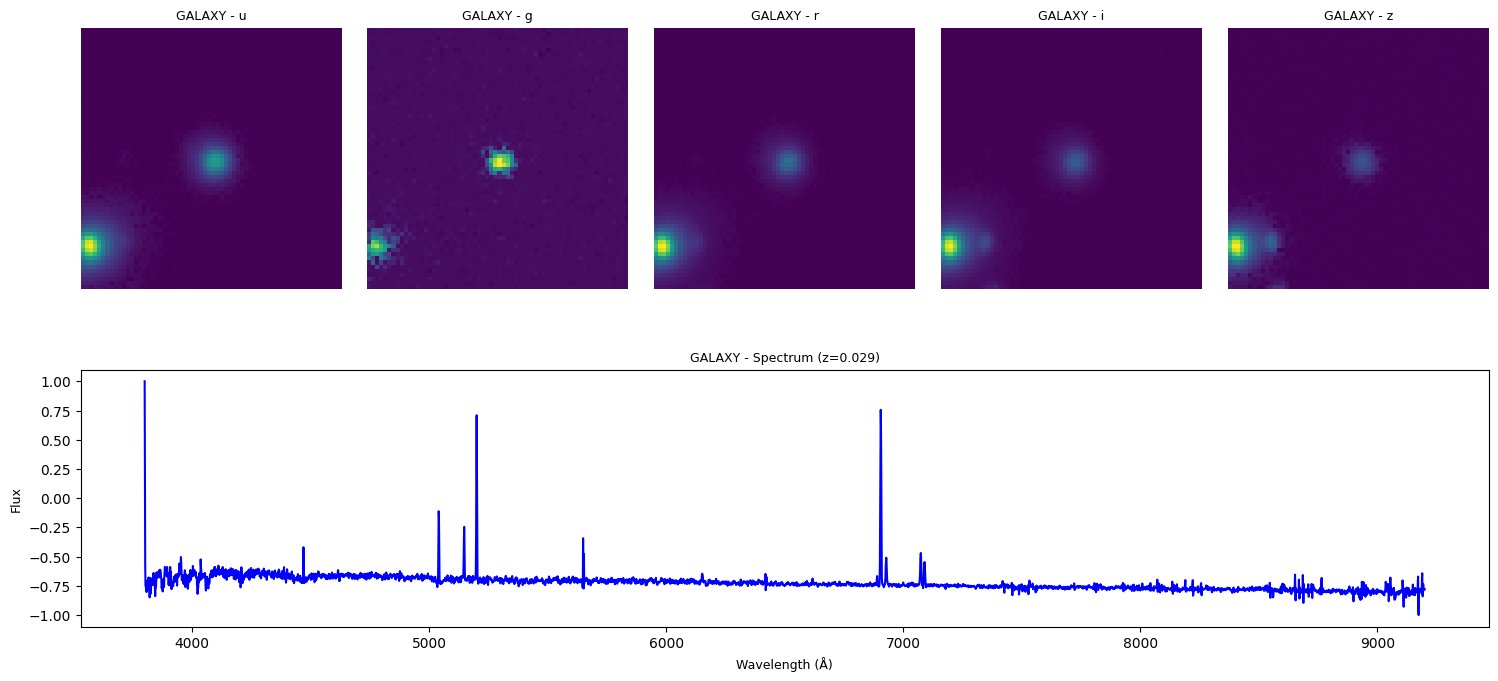

In [12]:
for i in range(1):
    plot_images_and_spectrum(images_filtered, spectra_normalized, labels_simplified, redshifts, "GALAXY", i)

# Machine Learning for Z

In [13]:
indices = np.arange(redshifts.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
y_train = redshifts[train_idx]
y_test = redshifts[test_idx]

In [14]:
X_spec_train = spectra_normalized[train_idx]
X_spec_test = spectra_normalized[test_idx]

X_photo = images_filtered[:, :, :, :].reshape(images_filtered.shape[0], -1)
X_photo_train = X_photo[train_idx]
X_photo_test = X_photo[test_idx]

X_comb_train = np.concatenate([X_spec_train, X_photo_train], axis=1)
X_comb_test = np.concatenate([X_spec_test, X_photo_test], axis=1)

In [15]:
spec_model_dtr = DecisionTreeRegressor(max_depth=50, random_state=42)
spec_model_dtr.fit(X_spec_train, y_train)
y_pred_spec_dtr = spec_model_dtr.predict(X_spec_test)

In [16]:
photo_model_dtr = DecisionTreeRegressor(max_depth=50, random_state=42)
photo_model_dtr.fit(X_photo_train, y_train)
y_pred_photo_dtr = photo_model_dtr.predict(X_photo_test)

In [17]:
comb_model_dtr = DecisionTreeRegressor(max_depth=50, random_state=42)
comb_model_dtr.fit(X_comb_train, y_train)
y_pred_comb_dtr = comb_model_dtr.predict(X_comb_test)

In [18]:
scaler = StandardScaler()

X_spec_train_scaled = scaler.fit_transform(X_spec_train)
X_spec_test_scaled = scaler.transform(X_spec_test)

X_photo_train_scaled = scaler.fit_transform(X_photo_train)
X_photo_test_scaled = scaler.transform(X_photo_test)

X_comb_train_scaled = scaler.fit_transform(X_comb_train)
X_comb_test_scaled = scaler.transform(X_comb_test)

In [19]:
X_spec_train_scaled

array([[-0.46768814, -0.5315366 , -0.6219548 , ..., -1.5464433 ,
        -1.5651454 , -1.564381  ],
       [ 0.8022032 ,  0.07445304, -0.4182685 , ...,  1.3844675 ,
         1.111775  ,  0.7886977 ],
       [-0.19056578, -0.41781297, -0.24509616, ..., -0.4025031 ,
        -0.29363284, -0.16730161],
       ...,
       [ 0.52287805,  0.44481686,  0.56612617, ...,  0.49658474,
         0.54478276,  0.5938005 ],
       [-0.10762291,  0.7969804 ,  2.2958782 , ..., -0.37230918,
        -0.27463424, -0.15932336],
       [-0.56209314, -0.89948106, -0.2985997 , ...,  1.1457591 ,
         1.2407253 ,  1.3362253 ]], dtype=float32)

In [20]:
print("Mean:", np.mean(X_spec_train_scaled, axis=0))  
print("Std Dev:", np.std(X_spec_train_scaled, axis=0))

Mean: [-7.2914550e-09 -5.4319340e-09  3.4990985e-10 ... -4.0856140e-08
 -1.8661860e-10  1.4196343e-08]
Std Dev: [0.99999857 0.9999993  0.9999999  ... 1.0000004  0.99999994 0.9999995 ]


In [21]:
def train_tabnet(X_train, y_train, X_test):
    model = TabNetRegressor(
    n_d=64,     # Dimension of hidden layers
    n_a=64,     # The dimension of attention
    n_steps=7,  
    gamma=1.5,  # We reinforce the importance of signs
    lambda_sparse=0.0001,  # Regularization (reduces overfitting)
    momentum=0.7,  # Helps to combat noise
    mask_type="entmax"  # Improved mask
)
    model.fit(X_train, y_train.reshape(-1, 1), max_epochs=200, patience=30, batch_size=256, virtual_batch_size=128)
    return model.predict(X_test).flatten()

y_pred_spec_tab = train_tabnet(X_spec_train_scaled, y_train, X_spec_test_scaled)
y_pred_photo_tab = train_tabnet(X_photo_train_scaled, y_train, X_photo_test_scaled)
y_pred_comb_tab = train_tabnet(X_comb_train_scaled, y_train, X_comb_test_scaled)

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.58094 |  0:00:02s
epoch 1  | loss: 1.15593 |  0:00:03s
epoch 2  | loss: 0.28412 |  0:00:05s
epoch 3  | loss: 0.00897 |  0:00:07s
epoch 4  | loss: 0.00637 |  0:00:08s
epoch 5  | loss: 0.00571 |  0:00:10s
epoch 6  | loss: 0.00483 |  0:00:12s
epoch 7  | loss: 0.0048  |  0:00:14s
epoch 8  | loss: 0.00478 |  0:00:15s
epoch 9  | loss: 0.00454 |  0:00:17s
epoch 10 | loss: 0.00453 |  0:00:19s
epoch 11 | loss: 0.00455 |  0:00:20s
epoch 12 | loss: 0.00458 |  0:00:22s
epoch 13 | loss: 0.00477 |  0:00:24s
epoch 14 | loss: 0.00473 |  0:00:26s
epoch 15 | loss: 0.00479 |  0:00:27s
epoch 16 | loss: 0.00463 |  0:00:29s
epoch 17 | loss: 0.00476 |  0:00:31s
epoch 18 | loss: 0.0048  |  0:00:32s
epoch 19 | loss: 0.00493 |  0:00:34s
epoch 20 | loss: 0.00504 |  0:00:36s
epoch 21 | loss: 0.0048  |  0:00:37s
epoch 22 | loss: 0.00461 |  0:00:39s
epoch 23 | loss: 0.00461 |  0:00:41s
epoch 24 | loss: 0.00457 |  0:00:43s
epoch 25 | loss: 0.00466 |  0:00:44s
epoch 26 | loss: 0.00446 |  0:00:46s
e

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 7.09788 |  0:00:09s
epoch 1  | loss: 3.0944  |  0:00:18s
epoch 2  | loss: 4.00904 |  0:00:27s
epoch 3  | loss: 0.79404 |  0:00:37s
epoch 4  | loss: 0.0867  |  0:00:46s
epoch 5  | loss: 0.02604 |  0:00:55s
epoch 6  | loss: 0.02048 |  0:01:05s
epoch 7  | loss: 0.01584 |  0:01:14s
epoch 8  | loss: 0.00858 |  0:01:23s
epoch 9  | loss: 0.00443 |  0:01:32s
epoch 10 | loss: 0.00412 |  0:01:42s
epoch 11 | loss: 0.00416 |  0:01:51s
epoch 12 | loss: 0.004   |  0:02:00s
epoch 13 | loss: 0.00399 |  0:02:09s
epoch 14 | loss: 0.00417 |  0:02:19s
epoch 15 | loss: 0.00396 |  0:02:28s
epoch 16 | loss: 0.00385 |  0:02:37s
epoch 17 | loss: 0.0039  |  0:02:47s
epoch 18 | loss: 0.00384 |  0:02:56s
epoch 19 | loss: 0.00374 |  0:03:05s
epoch 20 | loss: 0.00374 |  0:03:14s
epoch 21 | loss: 0.00368 |  0:03:24s
epoch 22 | loss: 0.00369 |  0:03:33s
epoch 23 | loss: 0.00369 |  0:03:42s
epoch 24 | loss: 0.00378 |  0:03:51s
epoch 25 | loss: 0.00376 |  0:04:01s
epoch 26 | loss: 0.00371 |  0:04:10s
e

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 7.69686 |  0:00:13s
epoch 1  | loss: 2.82014 |  0:00:26s
epoch 2  | loss: 0.48794 |  0:00:40s
epoch 3  | loss: 0.14731 |  0:00:53s
epoch 4  | loss: 0.01684 |  0:01:06s
epoch 5  | loss: 0.00696 |  0:01:20s
epoch 6  | loss: 0.00472 |  0:01:33s
epoch 7  | loss: 0.00463 |  0:01:46s
epoch 8  | loss: 0.00522 |  0:02:00s
epoch 9  | loss: 0.00464 |  0:02:13s
epoch 10 | loss: 0.00444 |  0:02:26s
epoch 11 | loss: 0.00436 |  0:02:39s
epoch 12 | loss: 0.00437 |  0:02:53s
epoch 13 | loss: 0.00444 |  0:03:06s
epoch 14 | loss: 0.00463 |  0:03:19s
epoch 15 | loss: 0.00438 |  0:03:33s
epoch 16 | loss: 0.00426 |  0:03:46s
epoch 17 | loss: 0.00419 |  0:03:59s
epoch 18 | loss: 0.00411 |  0:04:12s
epoch 19 | loss: 0.00425 |  0:04:26s
epoch 20 | loss: 0.00418 |  0:04:39s
epoch 21 | loss: 0.00411 |  0:04:52s
epoch 22 | loss: 0.00406 |  0:05:06s
epoch 23 | loss: 0.00401 |  0:05:19s
epoch 24 | loss: 0.00411 |  0:05:32s
epoch 25 | loss: 0.00409 |  0:05:46s
epoch 26 | loss: 0.00408 |  0:05:59s
e

In [22]:
y_mean = np.full_like(y_test, np.mean(y_train))
mae_mean = mean_absolute_error(y_test, y_mean)

mae_spec_tab = mean_absolute_error(y_test, y_pred_spec_tab)
mae_photo_tab = mean_absolute_error(y_test, y_pred_photo_tab)
mae_comb_tab = mean_absolute_error(y_test, y_pred_comb_tab)

mae_spec_dtr = mean_absolute_error(y_test, y_pred_spec_dtr)
mae_photo_dtr = mean_absolute_error(y_test, y_pred_photo_dtr)
mae_comb_dtr = mean_absolute_error(y_test, y_pred_comb_dtr)


print("Mean model MAE:", mae_mean)

print("Spectrum model MAE for (DTR):", mae_spec_dtr)
print("Photo model MAE for (DTR):", mae_photo_dtr)
print("Combination model MAE for (DTR):", mae_comb_dtr)

print("Spectrum model MAE (TabNet):", mae_spec_tab)
print("Photo model MAE (TabNet):", mae_photo_tab)
print("Combination model MAE (TabNet):", mae_comb_tab)

Mean model MAE: 0.05112766474485397
Spectrum model MAE for (DTR): 0.05926694061171628
Photo model MAE for (DTR): 0.05033363416863435
Combination model MAE for (DTR): 0.049162221174779926
Spectrum model MAE (TabNet): 0.051913388073444366
Photo model MAE (TabNet): 0.046927567571401596
Combination model MAE (TabNet): 0.0470304898917675


In [23]:
df_results = pd.DataFrame({
    "y_test": y_test,
    "y_pred_spec_dtr": y_pred_spec_dtr,
    "y_pred_photo_dtr": y_pred_photo_dtr,
    "y_pred_comb_dtr": y_pred_comb_dtr,
    "y_pred_spec_tab": y_pred_spec_tab,
    "y_pred_photo_tab": y_pred_photo_tab,
    "y_pred_comb_tab": y_pred_comb_tab,
    "y_mean": y_mean
})

print(df_results.head(10))

     y_test  y_pred_spec_dtr  y_pred_photo_dtr  y_pred_comb_dtr  \
0  0.049449         0.141128          0.211281         0.156511   
1  0.223478         0.225984          0.209274         0.210264   
2  0.068231         0.160077          0.247732         0.264685   
3  0.056101         0.060701          0.050498         0.040837   
4  0.111342         0.202809          0.206042         0.209531   
5  0.199471         0.151210          0.143048         0.179218   
6  0.233084         0.053526          0.211972         0.235410   
7  0.107604         0.110218          0.060403         0.091110   
8  0.135551         0.136386          0.116603         0.129551   
9  0.213894         0.125682          0.107715         0.092993   

   y_pred_spec_tab  y_pred_photo_tab  y_pred_comb_tab    y_mean  
0         0.102851          0.154130         0.148003  0.126833  
1         0.131001          0.170579         0.130748  0.126833  
2         0.123611          0.171571         0.133573  0.126833 

# Visualization

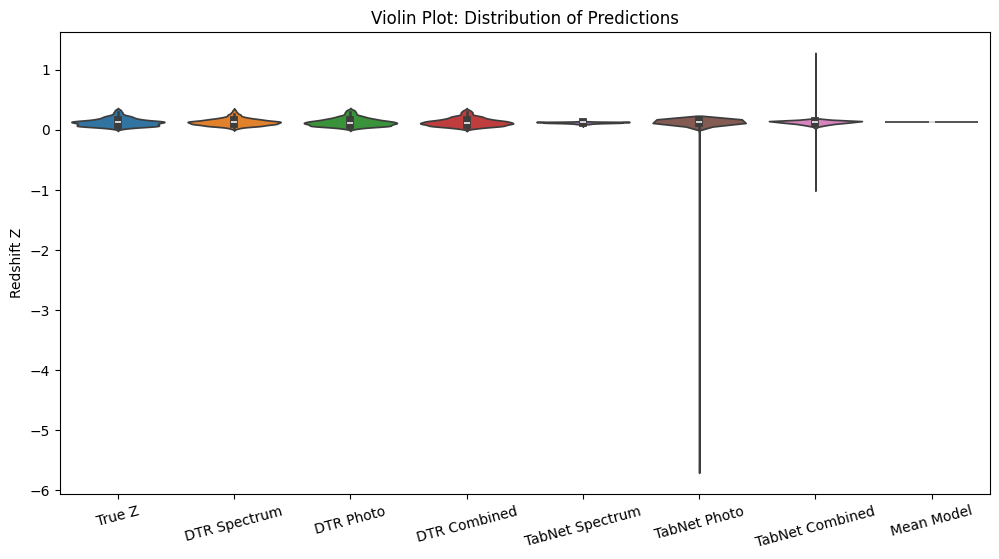

In [24]:
data = [y_test, y_pred_spec_dtr, y_pred_photo_dtr, y_pred_comb_dtr, y_pred_spec_tab, y_pred_photo_tab, y_pred_comb_tab, y_mean]
labels = ["True Z", "DTR Spectrum", "DTR Photo", "DTR Combined", "TabNet Spectrum", "TabNet Photo", "TabNet Combined", "Mean Model"]

plt.figure(figsize=(12, 6))
sns.violinplot(data=data)
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=15)
plt.title("Violin Plot: Distribution of Predictions")
plt.ylabel("Redshift Z")
plt.show()

In [25]:
def plot_parity(ax, y_true, y_pred, title):
    ax.scatter(y_true, y_pred, alpha=0.7, edgecolors='b')
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Fit')
    ax.set_xlabel("Actual Z")
    ax.set_ylabel("Predicted Z")
    ax.set_title(title)
    ax.legend()

def plot_error_hist(ax, errors, title):
    sns.histplot(errors, bins=30, kde=True, ax=ax)
    ax.set_xlabel("Prediction Error (Z)")
    ax.set_ylabel("Count")
    ax.set_title(title)

def plot_distribution(ax, y_true, y_pred, title, bins=30, alpha=0.5):
    ax.hist(y_true, bins=bins, alpha=alpha, label="Actual Z")
    ax.hist(y_pred, bins=bins, alpha=alpha, label="Predicted Z")
    ax.set_xlabel("Redshift (Z)")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    ax.legend()

def plot_residual(ax, y_pred, residuals, title):
    ax.scatter(y_pred, residuals, alpha=0.7, edgecolors='b')
    ax.axhline(y=0, color='red', linestyle='--', label='Ideal Fit')
    ax.set_xlabel("Predicted Z")
    ax.set_ylabel("Residual (Actual - Predicted)")
    ax.set_title(title)
    ax.legend()

### Distribution

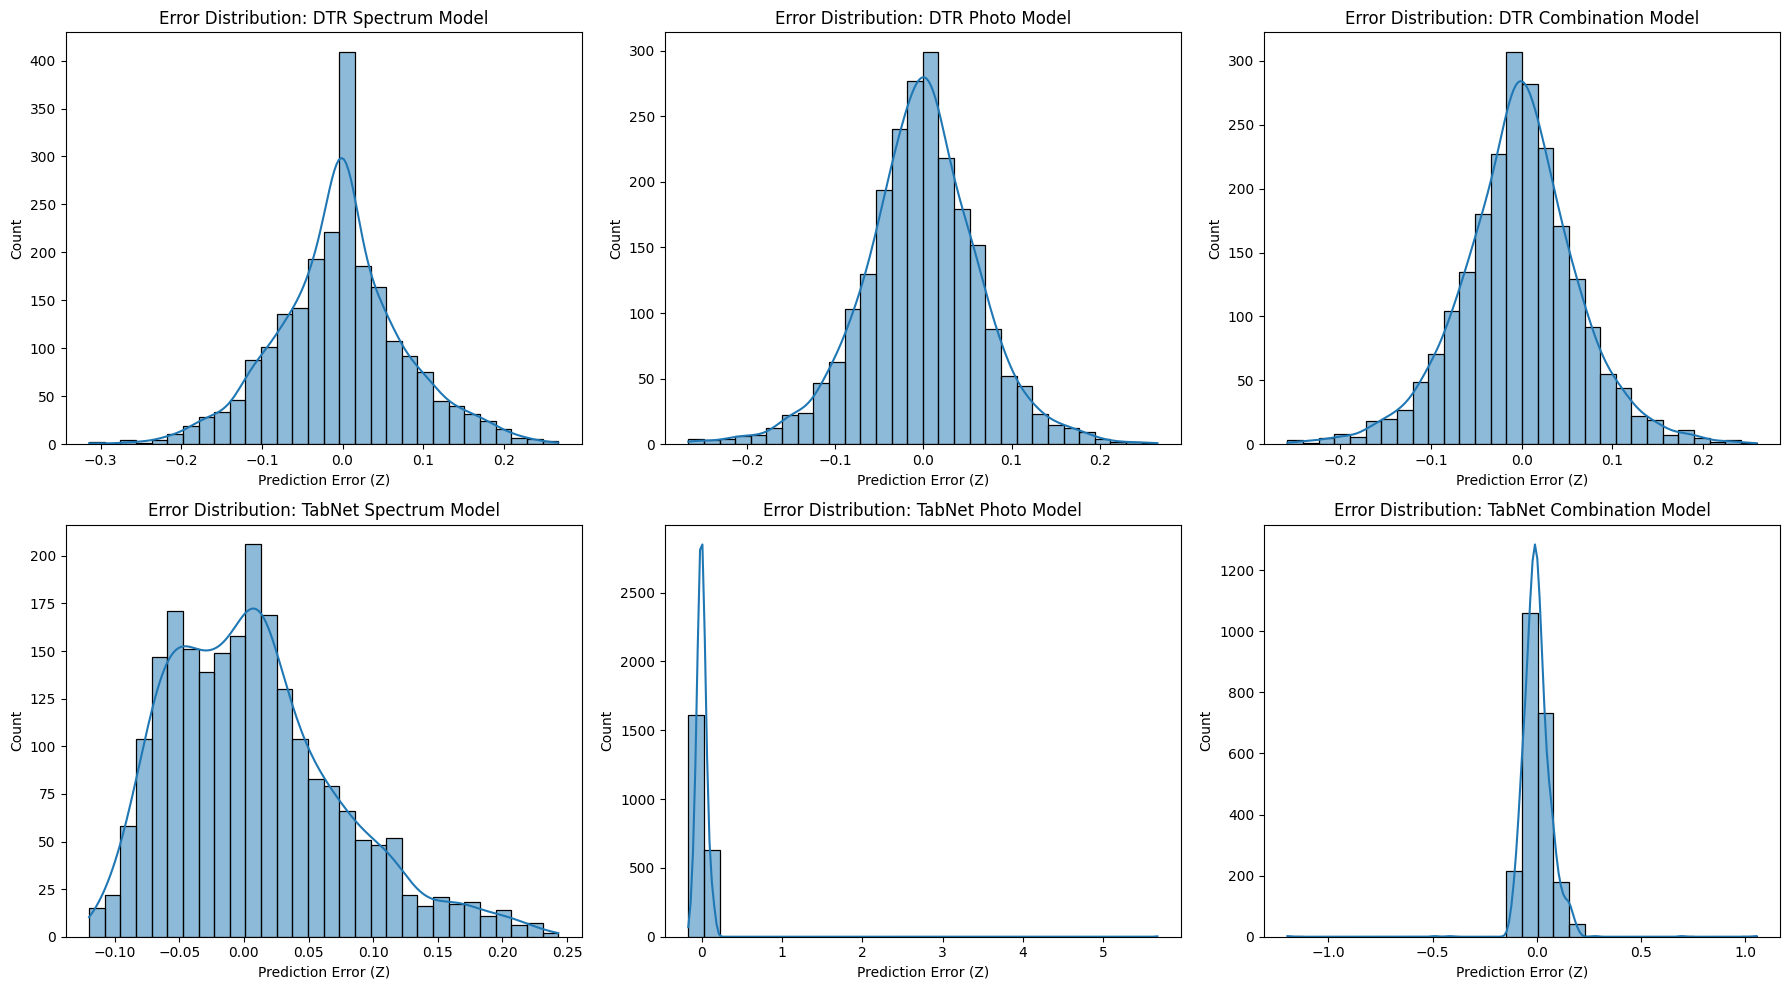

In [26]:
errors_spec_dtr = y_test - y_pred_spec_dtr
errors_photo_dtr = y_test - y_pred_photo_dtr
errors_comb_dtr = y_test - y_pred_comb_dtr

errors_spec_tab = y_test - y_pred_spec_tab
errors_photo_tab = y_test - y_pred_photo_tab
errors_comb_tab = y_test - y_pred_comb_tab

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
plot_error_hist(axs[0, 0], errors_spec_dtr, "Error Distribution: DTR Spectrum Model")
plot_error_hist(axs[0, 1], errors_photo_dtr, "Error Distribution: DTR Photo Model")
plot_error_hist(axs[0, 2], errors_comb_dtr, "Error Distribution: DTR Combination Model")
plot_error_hist(axs[1, 0], errors_spec_tab, "Error Distribution: TabNet Spectrum Model")
plot_error_hist(axs[1, 1], errors_photo_tab, "Error Distribution: TabNet Photo Model")
plot_error_hist(axs[1, 2], errors_comb_tab, "Error Distribution: TabNet Combination Model")
plt.tight_layout()
plt.show()

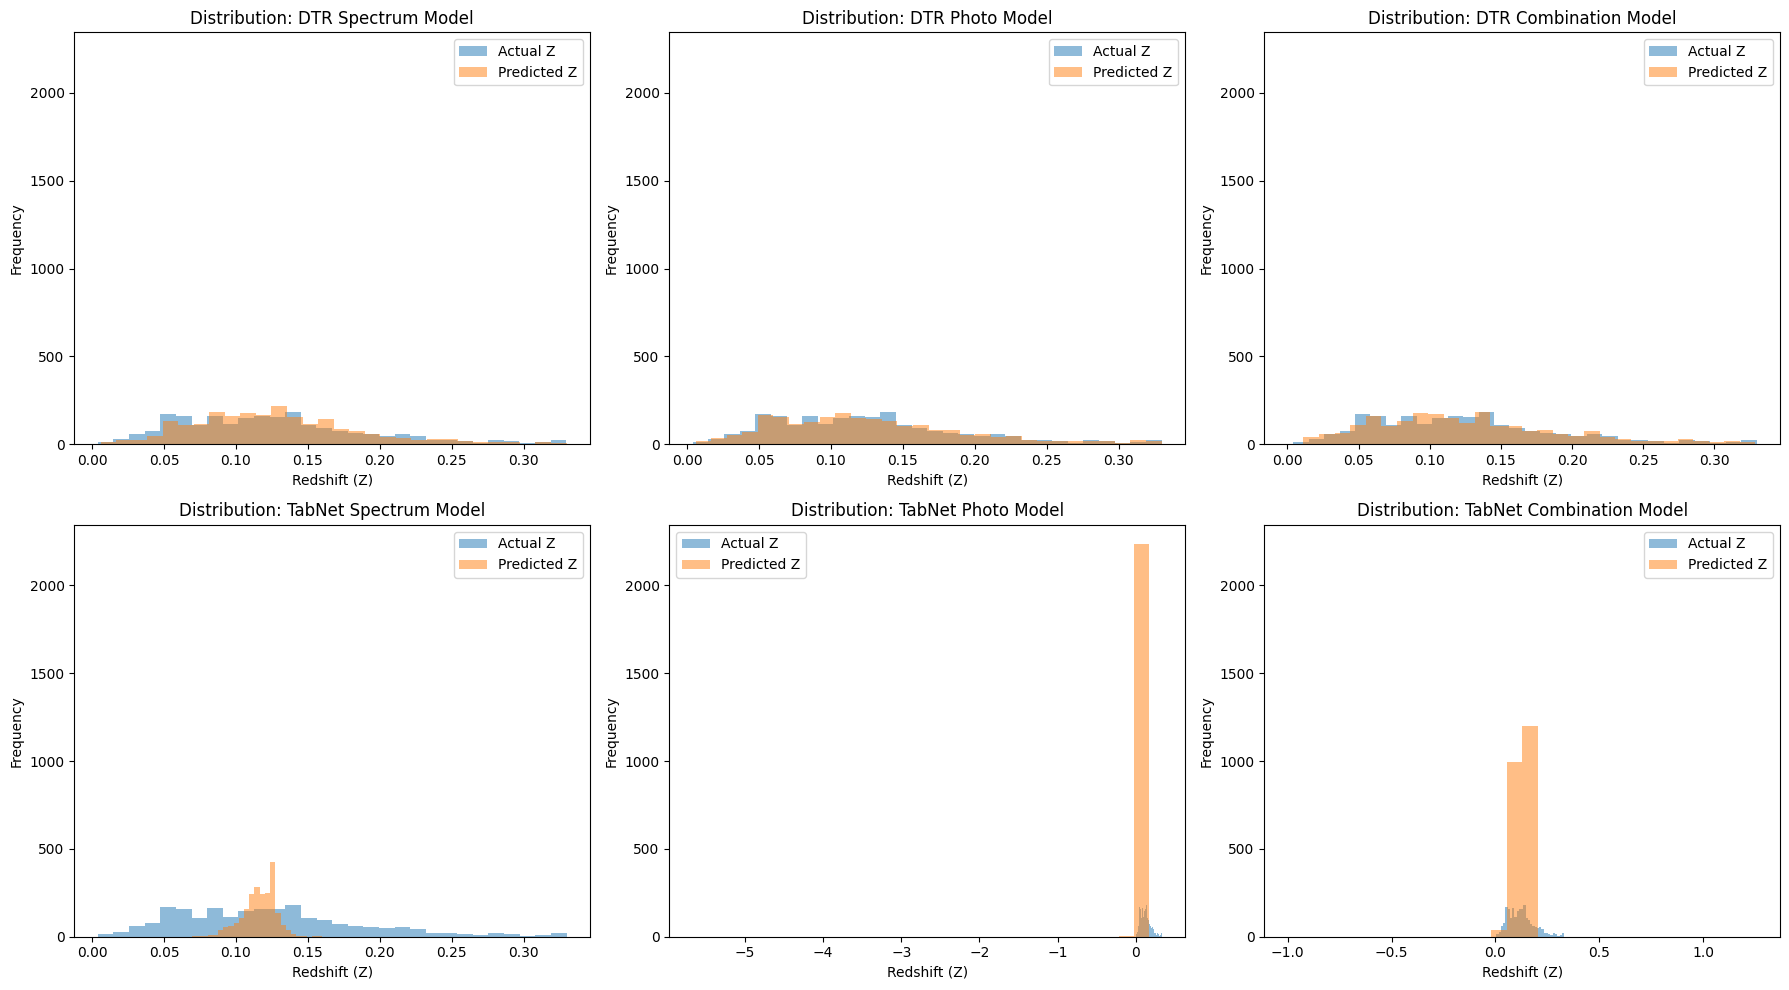

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_distribution(axs[0, 0], y_test, y_pred_spec_dtr, "Distribution: DTR Spectrum Model")
plot_distribution(axs[0, 1], y_test, y_pred_photo_dtr, "Distribution: DTR Photo Model")
plot_distribution(axs[0, 2], y_test, y_pred_comb_dtr, "Distribution: DTR Combination Model")

plot_distribution(axs[1, 0], y_test, y_pred_spec_tab, "Distribution: TabNet Spectrum Model")
plot_distribution(axs[1, 1], y_test, y_pred_photo_tab, "Distribution: TabNet Photo Model")
plot_distribution(axs[1, 2], y_test, y_pred_comb_tab, "Distribution: TabNet Combination Model")

common_ylim = max(ax.get_ylim()[1] for row in axs for ax in row)

for row in axs:
    for ax in row:
        ax.set_ylim(0, common_ylim)

plt.tight_layout()
plt.show()


### Parity Plot

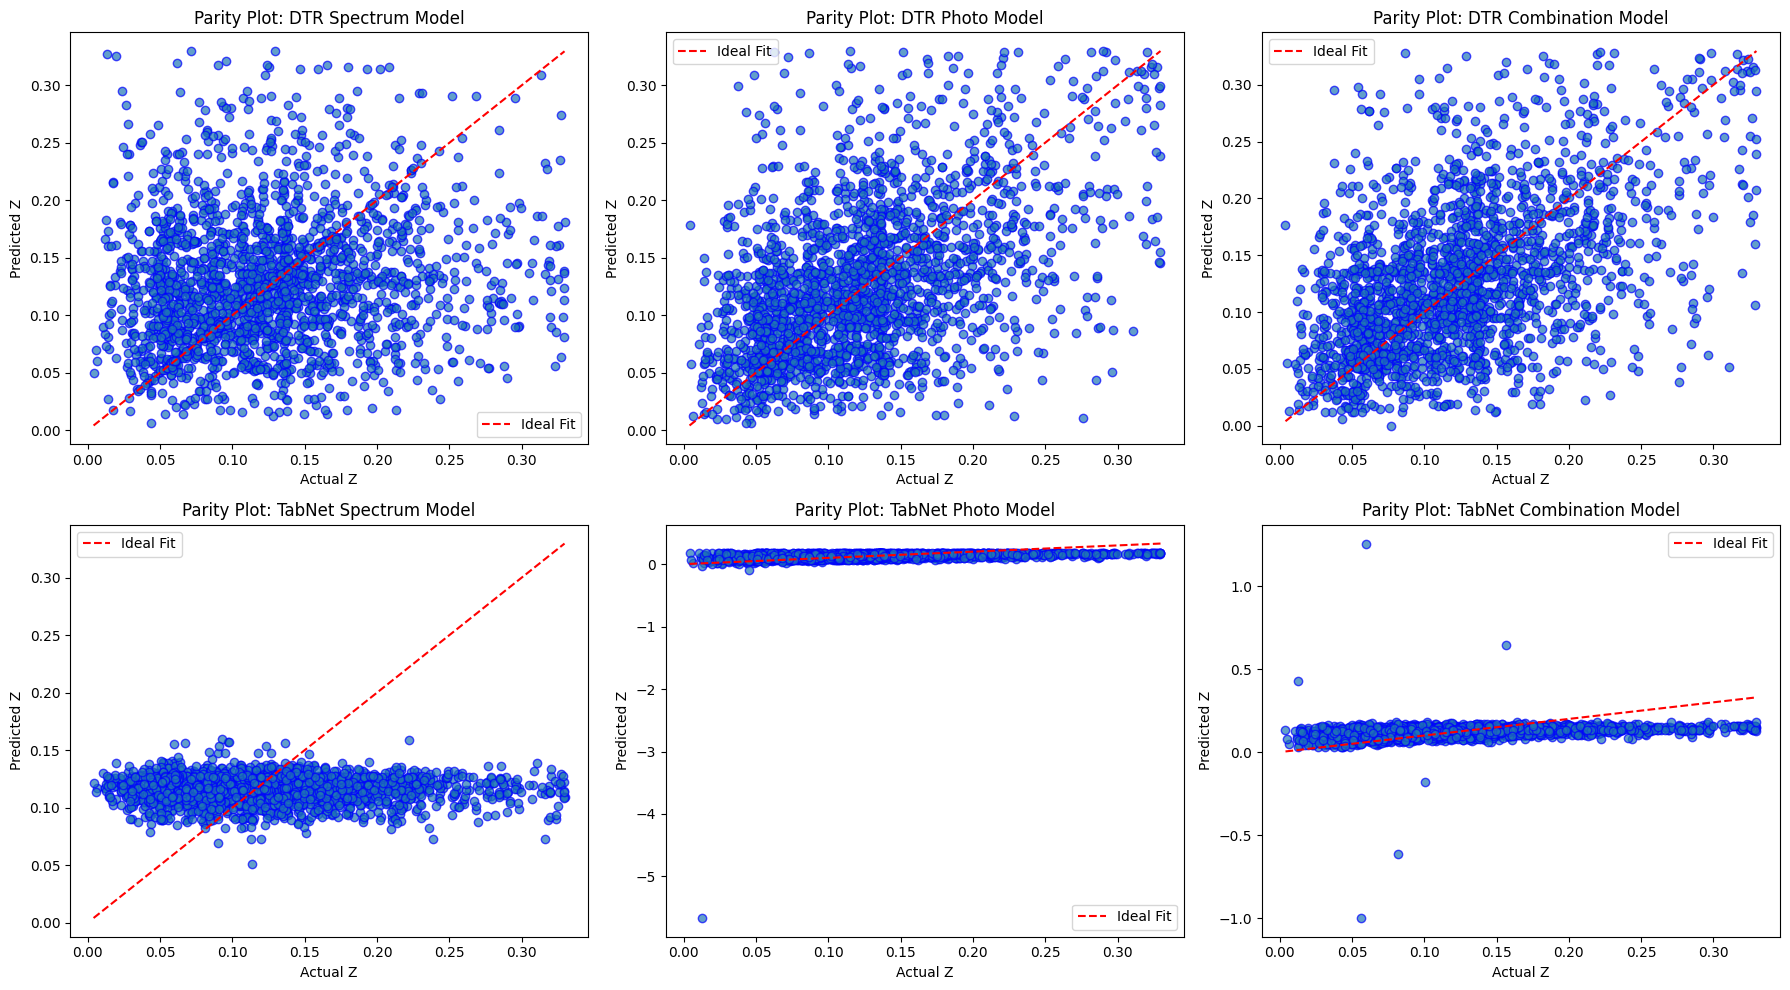

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
plot_parity(axs[0, 0], y_test, y_pred_spec_dtr, "Parity Plot: DTR Spectrum Model")
plot_parity(axs[0, 1], y_test, y_pred_photo_dtr, "Parity Plot: DTR Photo Model")
plot_parity(axs[0, 2], y_test, y_pred_comb_dtr, "Parity Plot: DTR Combination Model")
plot_parity(axs[1, 0], y_test, y_pred_spec_tab, "Parity Plot: TabNet Spectrum Model")
plot_parity(axs[1, 1], y_test, y_pred_photo_tab, "Parity Plot: TabNet Photo Model")
plot_parity(axs[1, 2], y_test, y_pred_comb_tab, "Parity Plot: TabNet Combination Model")
plt.tight_layout()
plt.show()

### Residual Plot

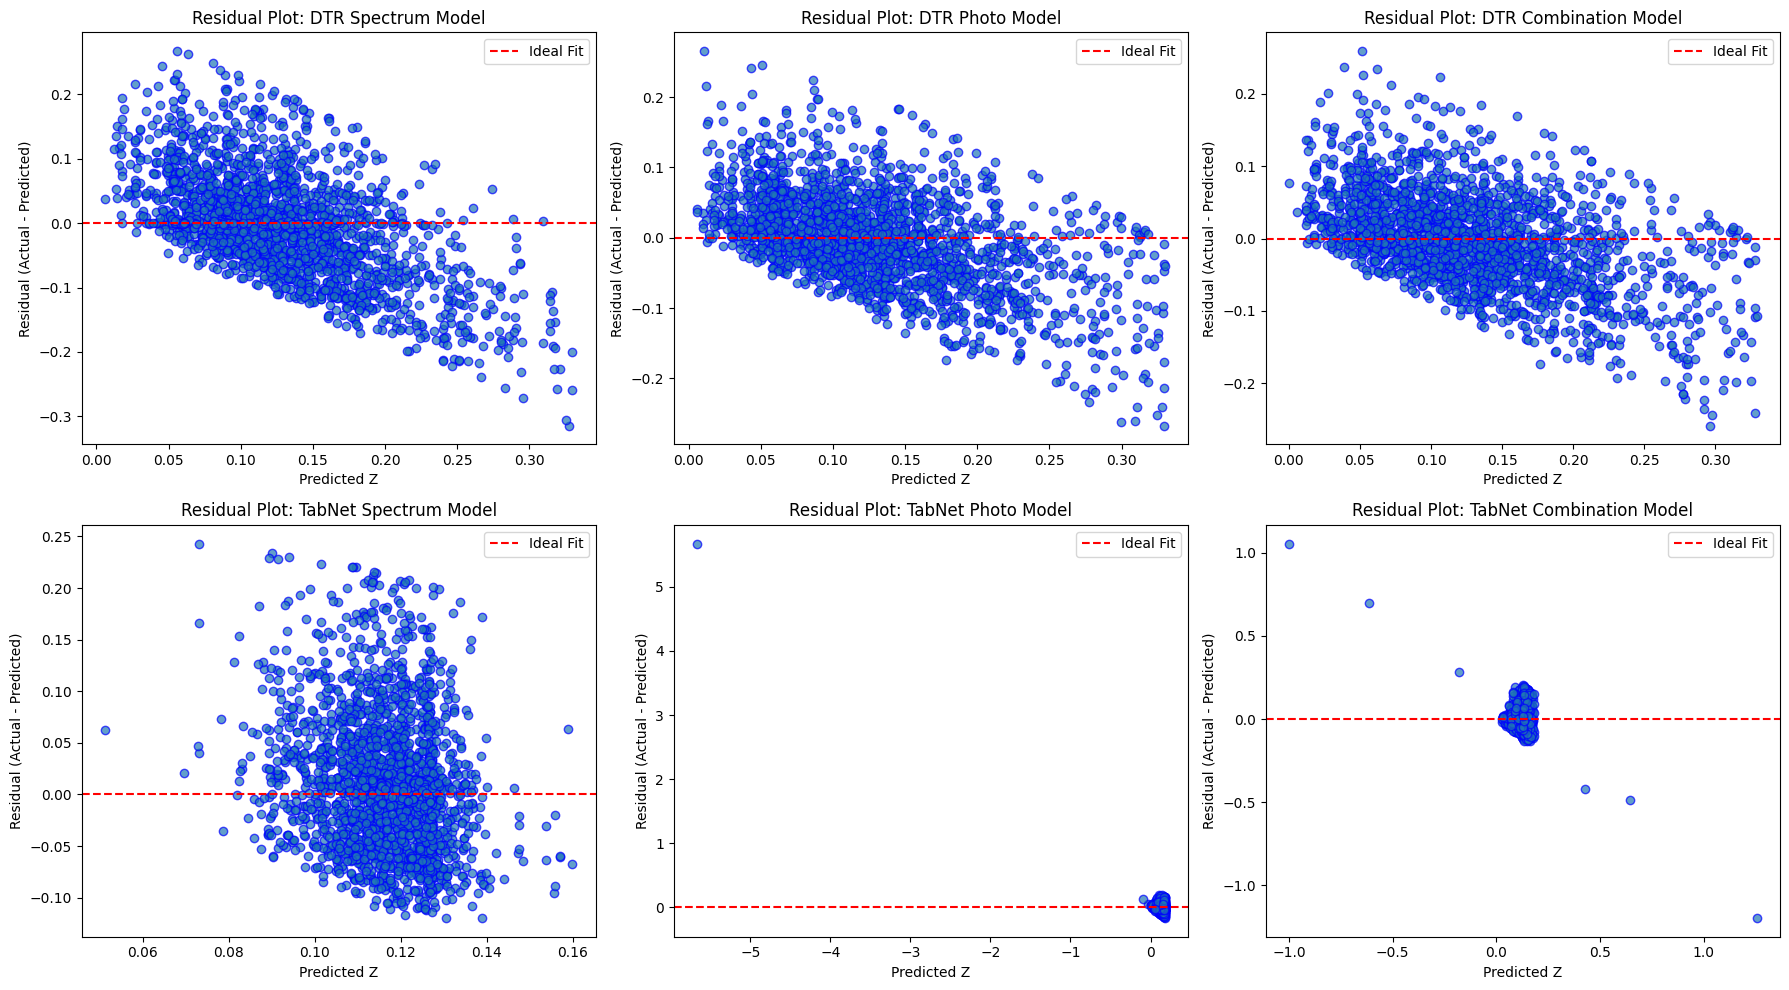

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
plot_residual(axs[0, 0], y_pred_spec_dtr, errors_spec_dtr, "Residual Plot: DTR Spectrum Model")
plot_residual(axs[0, 1], y_pred_photo_dtr, errors_photo_dtr, "Residual Plot: DTR Photo Model")
plot_residual(axs[0, 2], y_pred_comb_dtr, errors_comb_dtr, "Residual Plot: DTR Combination Model")
plot_residual(axs[1, 0], y_pred_spec_tab, errors_spec_tab, "Residual Plot: TabNet Spectrum Model")
plot_residual(axs[1, 1], y_pred_photo_tab, errors_photo_tab, "Residual Plot: TabNet Photo Model")
plot_residual(axs[1, 2], y_pred_comb_tab, errors_comb_tab, "Residual Plot: TabNet Combination Model")
plt.tight_layout()
plt.show()